In [1]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import plotly.express as px



## Parameters and Basic settings

In [2]:
E = 0.032
nu = 0.4

C=(E/((1+nu)*(1-2*nu)))*torch.tensor(
    [[1-nu,nu,nu,0,0,0],
     [nu,1-nu,nu,0,0,0],
     [nu,nu,1-nu,0,0,0],
     [0,0,0,(1-2*nu)/2,0,0],
     [0,0,0,0,(1-2*nu)/2,0],
     [0,0,0,0,0,(1-2*nu)/2]]).cuda()

G = E/(2*(1+nu))
#Force = 1.
seed_id = 1234
lr = 1e-3
nneurons = 20
nhiden_layers = 4
#Nf_x = 50 # Number of collocation points in x direction
#Nf_y = 20 # Number of collocation points in y direction
#N_bc = 30 # Number of boundary points

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(device))

# Set default dtype to float32
torch.set_default_dtype(torch.float32)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

Using device: cuda
NVIDIA A2


## Normalization

In [3]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

## Loading data SOL1

In [4]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [5]:
#posicion inicial de los nodos 

ititialPosition_data_path = "./data/ARTURO_TEST_1/NODES.txt"

with open(ititialPosition_data_path,"r") as f:
    aux_list=f.readlines()

ititialPosition_data=[i for i in aux_list if keep_line(i)]
ititialPosition_data=[i.strip("\n") for i in ititialPosition_data]
ititialPosition_data=[i.split() for i in ititialPosition_data]
ititialPosition_data_np=np.array(ititialPosition_data).astype(float)[:,[0,1,2,3]]
ititialPosition_data_pd=pd.DataFrame(ititialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
ititialPosition_data_pd

,X,Y,Z
Node,,,
1.0,46.726,41.840,17.459
2.0,31.149,44.342,17.410
3.0,54.619,26.576,39.528
4.0,63.720,39.982,42.026
5.0,19.543,50.820,41.746
...,...,...,...
4147.0,47.957,36.969,40.653
4148.0,43.244,36.666,35.819
4149.0,46.140,37.853,37.430


In [6]:
#cargar datos de stress

stress_data_path = "./data/LINEAR_SMALL_DISP/PSOL_10_NODAL_STRESSES.txt"

with open(stress_data_path,"r") as f:
    aux_list=f.readlines()


stress_data=[i for i in aux_list if keep_line(i)]
stress_data=[i.strip("\n").strip() for i in stress_data]
patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

stress_data=[re.findall(patron,i) for i in stress_data]
stress_data=np.array(stress_data,dtype=float)
stress_data=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")
stress_data

,SX,SY,SZ,SXY,SYZ,SXZ
Node,,,,,,
1.0,0.000636,-0.000977,0.000060,0.000581,0.000165,0.000284
2.0,0.000533,-0.001960,0.000172,-0.000703,0.000093,-0.000284
3.0,-0.000683,-0.001899,-0.000488,0.000108,-0.000060,-0.000340
4.0,0.000155,0.000046,0.000146,-0.000109,-0.000693,0.000093
5.0,-0.000326,-0.000673,0.003965,-0.001020,-0.001728,-0.000881
...,...,...,...,...,...,...
1670.0,-0.000053,-0.000066,0.000551,0.000068,-0.000457,0.000153
1671.0,-0.000007,0.000008,0.000384,0.000052,-0.000390,-0.000047
1672.0,-0.000072,-0.000071,0.000387,0.000003,-0.000616,0.000226


In [7]:
# cargar datos de desplazamiento  
displacement_data_path = "./data/LINEAR_SMALL_DISP/PSOL_10_NODAL_DISP.txt"

with open(displacement_data_path,"r") as f:
    aux_list=f.readlines()


displacement_data=[i for i in aux_list if keep_line(i)]
displacement_data=[i.strip("\n").strip() for i in displacement_data]
patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

displacement_data=[re.findall(patron,i) for i in displacement_data]

In [8]:

displacement_data=np.array(displacement_data,dtype=float)
displacement_data=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")
displacement_data

,UX,UY,UZ,USUM
Node,,,,
1.0,0.383590,-1.64530,-0.519970,1.76760
2.0,-0.317510,-1.94210,-0.684740,2.08360
3.0,0.197710,0.00000,0.085179,0.21528
4.0,0.212900,-0.21741,-0.096805,0.31932
5.0,-0.142780,-0.44734,0.251500,0.53268
...,...,...,...,...
4147.0,0.227120,-0.64232,0.380410,0.78030
4148.0,0.096754,-0.75938,0.206120,0.79278
4149.0,0.156120,-0.75100,0.271850,0.81380


In [9]:
# cargar datos de boundaries en el movimiento
#cargar los nodos fijos
with open("./data/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
    restricted_data=f.readlines()

restricted_data=[i for i in restricted_data if keep_line(i)]
restricted_data=[i.strip("\n") for i in restricted_data]
restricted_data=[i.split() for i in restricted_data]
restricted_data_np=np.array(restricted_data)[:,[0,1]]
restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
restricted_data_pd=restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
restricted_data_pd.index=restricted_data_pd.index.astype(int)
restricted_data_pd=restricted_data_pd.sort_index()
restricted_data_pd=restricted_data_pd.rename(columns={"Direccion":"Restricciones"})
restricted_data_pd

,Restricciones
Node,
3,[UY]
7,[UY]
23,[UY]
24,[UY]
25,[UY]
...,...
3263,"[UX, UY, UZ]"
3264,"[UX, UY, UZ]"
3290,"[UX, UY, UZ]"


Las limitaciones en todas las direcciones las tenemos en los contactos laterales con la cadera. Y la restricción de movimiento en Y, la tenemos en la pared donde se aplica la presión.  

En nuestro caso concreto, esta restricción que se está aplicando sobre los desplazamientos de algunos nodos solo en Y no es en la misma zona donde se está aplicando la fuerza.  


In [10]:
with open("./data/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
    force_data=f.readlines()


force_data=[i for i in force_data if keep_line(i)]
force_data=[i.strip("\n") for i in force_data]
force_data=[i.split() for i in force_data]
force_data_np=np.array(force_data)[:,[0,1,2]]
force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
force_data_pd["Fuerza"]=force_data_pd["Fuerza"].astype(float)
force_data_pd=force_data_pd.set_index("Node")
force_data_pd.index=force_data_pd.index.astype(int)
force_data_pd

,Direccion_Fuerza,Fuerza
Node,,
6,FY,-0.02
181,FY,-0.02
182,FY,-0.02
183,FY,-0.02
184,FY,-0.02
...,...,...
2568,FY,-0.02
2569,FY,-0.02
2571,FY,-0.02


In [11]:
#ponemos todos los datos en común usando los nodos como clave   
final_data=ititialPosition_data_pd.merge(stress_data,left_index=True,right_index=True,how="left").merge(force_data_pd,left_index=True,right_index=True,how="left").merge(displacement_data,left_index=True,right_index=True,how="left").merge(restricted_data_pd,left_index=True,right_index=True,how="left")
final_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones
Node,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000636,-0.000977,0.000060,0.000581,0.000165,0.000284,NaN,NaN,0.383590,-1.64530,-0.519970,1.76760,NaN
2.0,31.149,44.342,17.410,0.000533,-0.001960,0.000172,-0.000703,0.000093,-0.000284,NaN,NaN,-0.317510,-1.94210,-0.684740,2.08360,NaN
3.0,54.619,26.576,39.528,-0.000683,-0.001899,-0.000488,0.000108,-0.000060,-0.000340,NaN,NaN,0.197710,0.00000,0.085179,0.21528,[UY]
4.0,63.720,39.982,42.026,0.000155,0.000046,0.000146,-0.000109,-0.000693,0.000093,NaN,NaN,0.212900,-0.21741,-0.096805,0.31932,NaN
5.0,19.543,50.820,41.746,-0.000326,-0.000673,0.003965,-0.001020,-0.001728,-0.000881,NaN,NaN,-0.142780,-0.44734,0.251500,0.53268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227120,-0.64232,0.380410,0.78030,NaN
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096754,-0.75938,0.206120,0.79278,NaN
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156120,-0.75100,0.271850,0.81380,NaN


In [12]:
final_data.Direccion_Fuerza

Node
1.0       NaN
2.0       NaN
3.0       NaN
4.0       NaN
5.0       NaN
         ... 
4147.0    NaN
4148.0    NaN
4149.0    NaN
4150.0    NaN
4151.0    NaN
Name: Direccion_Fuerza, Length: 4151, dtype: object

In [13]:
final_data.loc[~final_data.Direccion_Fuerza.isna()]

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones
Node,,,,,,,,,,,,,,,,
6.0,27.108,57.070,47.311,-0.003914,-0.007067,-0.003272,-0.000960,0.002325,-0.000228,FY,-0.02,-0.022577,-2.6555,0.638280,2.7313,NaN
181.0,26.161,50.981,29.122,0.001909,-0.000448,0.001249,-0.001509,0.000435,-0.000824,FY,-0.02,0.000000,0.0000,0.000000,0.0000,"[UX, UY, UZ]"
182.0,26.443,50.288,27.876,0.001283,-0.002810,-0.000039,-0.002598,-0.000253,-0.001141,FY,-0.02,0.000000,0.0000,0.000000,0.0000,"[UX, UY, UZ]"
183.0,27.980,49.724,25.295,-0.000572,-0.007253,0.001545,-0.002296,0.002502,-0.001081,FY,-0.02,0.181340,-1.5804,-0.506880,1.6695,NaN
184.0,27.784,49.479,25.129,-0.003629,-0.013755,-0.001093,-0.004871,0.001492,-0.001278,FY,-0.02,0.105500,-1.4522,-0.484380,1.5345,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568.0,38.621,51.321,30.327,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.050114,-2.4721,-0.356600,2.4982,NaN
2569.0,37.562,52.301,32.492,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.072479,-2.7146,-0.180950,2.7216,NaN
2571.0,38.862,53.157,34.880,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.007598,-2.9383,0.007973,2.9383,NaN


In [14]:
color_aux=[]
for i,j in final_data.iterrows():
    if not np.isnan(j.Fuerza):
        if j.Restricciones==["UY"]:
            color_aux.append(1)
        else:
            color_aux.append(2)
    elif j.Restricciones==["UY"]:
        color_aux.append(3)
    else:
        color_aux.append(4)

In [15]:
final_data["Final_X"]=final_data["X"]-final_data["UX"]
final_data["Final_Y"]=final_data["Y"]-final_data["UY"]
final_data["Final_Z"]=final_data["Z"]-final_data["UZ"]
final_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z
Node,,,,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000636,-0.000977,0.000060,0.000581,0.000165,0.000284,NaN,NaN,0.383590,-1.64530,-0.519970,1.76760,NaN,46.342410,43.48530,17.978970
2.0,31.149,44.342,17.410,0.000533,-0.001960,0.000172,-0.000703,0.000093,-0.000284,NaN,NaN,-0.317510,-1.94210,-0.684740,2.08360,NaN,31.466510,46.28410,18.094740
3.0,54.619,26.576,39.528,-0.000683,-0.001899,-0.000488,0.000108,-0.000060,-0.000340,NaN,NaN,0.197710,0.00000,0.085179,0.21528,[UY],54.421290,26.57600,39.442821
4.0,63.720,39.982,42.026,0.000155,0.000046,0.000146,-0.000109,-0.000693,0.000093,NaN,NaN,0.212900,-0.21741,-0.096805,0.31932,NaN,63.507100,40.19941,42.122805
5.0,19.543,50.820,41.746,-0.000326,-0.000673,0.003965,-0.001020,-0.001728,-0.000881,NaN,NaN,-0.142780,-0.44734,0.251500,0.53268,NaN,19.685780,51.26734,41.494500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227120,-0.64232,0.380410,0.78030,NaN,47.729880,37.61132,40.272590
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096754,-0.75938,0.206120,0.79278,NaN,43.147246,37.42538,35.612880
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156120,-0.75100,0.271850,0.81380,NaN,45.983880,38.60400,37.158150


In [16]:
final_data["-UY"]=-1*final_data["UY"]


In [17]:
final_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z,-UY
Node,,,,,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000636,-0.000977,0.000060,0.000581,0.000165,0.000284,NaN,NaN,0.383590,-1.64530,-0.519970,1.76760,NaN,46.342410,43.48530,17.978970,1.64530
2.0,31.149,44.342,17.410,0.000533,-0.001960,0.000172,-0.000703,0.000093,-0.000284,NaN,NaN,-0.317510,-1.94210,-0.684740,2.08360,NaN,31.466510,46.28410,18.094740,1.94210
3.0,54.619,26.576,39.528,-0.000683,-0.001899,-0.000488,0.000108,-0.000060,-0.000340,NaN,NaN,0.197710,0.00000,0.085179,0.21528,[UY],54.421290,26.57600,39.442821,-0.00000
4.0,63.720,39.982,42.026,0.000155,0.000046,0.000146,-0.000109,-0.000693,0.000093,NaN,NaN,0.212900,-0.21741,-0.096805,0.31932,NaN,63.507100,40.19941,42.122805,0.21741
5.0,19.543,50.820,41.746,-0.000326,-0.000673,0.003965,-0.001020,-0.001728,-0.000881,NaN,NaN,-0.142780,-0.44734,0.251500,0.53268,NaN,19.685780,51.26734,41.494500,0.44734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227120,-0.64232,0.380410,0.78030,NaN,47.729880,37.61132,40.272590,0.64232
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096754,-0.75938,0.206120,0.79278,NaN,43.147246,37.42538,35.612880,0.75938
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156120,-0.75100,0.271850,0.81380,NaN,45.983880,38.60400,37.158150,0.75100


In [18]:
from sklearn.preprocessing import LabelEncoder

In [20]:
lb=LabelEncoder()

In [24]:
a=lb.fit_transform(final_data["Restricciones"].fillna(0).astype(str))

In [27]:
a2=np.where(a=0)

In [30]:
px.scatter_3d(final_data,x="X",y="Y",z="Z",color=a,color_continuous_scale="algae")


**EL AZUL =2 ES DONDE SE APLICA LA FUERZA**  
**EL  3 ES DONDE ESTA RESTRINGIDO A TENER UN MOVIMIENTO SIN Y**

¿Como proceder con todos los datos que tenemos ?  
**Tenemos datos de restricciones completas del movimiento y también parciales.**  
Para el caso de limitación total, podemos incluirlo en la loss de la data, o en el propio modelo. Para la restricción en una sola dirección, tambien podemos meterlo en la los de la data, pero deberá calcularse solo con las dos componentes que no se deben mover.   


**Tenemos una restricción que refiere a la fuerza aplicada**  
Esta restricción realmente es parte de la ecuación de equilibrio, pero la estamos añadiendo a parte. Se calcula con las tensiones, las cuales calculamos con los desplazamientos -> las deformaciones -> tensiones.  Una vez que tenemos las tensiones, las igualaremos a las que esta produciendo la fuerza aplicada.   



**Tenemos una loss física que será calculada con las propiedades del material y la divergencia de ¿?los desplazamientos¿?**   

In [31]:
final_data.loc[final_data.Restricciones.apply(lambda x: x==["UY"])]

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z,-UY
Node,,,,,,,,,,,,,,,,,,,,
3.0,54.619,26.576,39.528,-0.000683,-0.001899,-0.000488,0.000108,-0.000060,-0.000340,NaN,NaN,0.197710,0.0,0.085179,0.21528,[UY],54.421290,26.576,39.442821,-0.0
7.0,27.021,25.703,49.628,0.000693,-0.000967,0.000359,-0.000367,0.000230,0.000025,NaN,NaN,-0.163250,0.0,0.360790,0.39601,[UY],27.184250,25.703,49.267210,-0.0
23.0,27.451,25.543,50.376,0.001172,0.000006,0.000474,-0.000755,0.000111,-0.000049,NaN,NaN,-0.161000,0.0,0.365060,0.39898,[UY],27.612000,25.543,50.010940,-0.0
24.0,27.224,26.137,51.136,0.000256,-0.002291,-0.000275,-0.000642,-0.000008,-0.000043,NaN,NaN,-0.213210,0.0,0.363600,0.42150,[UY],27.437210,26.137,50.772400,-0.0
25.0,27.881,26.324,52.073,-0.000222,-0.003404,-0.000602,-0.000142,-0.000132,-0.000076,NaN,NaN,-0.230220,0.0,0.407330,0.46789,[UY],28.111220,26.324,51.665670,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165.0,38.785,26.499,44.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018722,0.0,0.450520,0.45091,[UY],38.766278,26.499,44.072480,-0.0
3166.0,33.868,26.459,51.721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074843,0.0,0.488060,0.49377,[UY],33.942843,26.459,51.232940,-0.0
3170.0,30.330,25.763,48.786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.111690,0.0,0.389170,0.40488,[UY],30.441690,25.763,48.396830,-0.0


In [21]:
a=final_data.loc[final_data.Direccion_Fuerza.apply(lambda x: x=="FY")]

In [22]:
a.describe()

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Fuerza,UX,UY,UZ,USUM,Final_X,Final_Y,Final_Z,-UY
count,228.000000,228.000000,228.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,2.280000e+02,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,38.541996,54.569873,36.321070,-0.003005,-0.005361,-0.001803,-0.000139,-0.000238,-0.000017,-2.000000e-02,-0.012373,-2.429117,0.103680,2.488512,38.554369,56.998990,36.217390,2.429117
std,8.433165,2.888071,8.161072,0.002117,0.003419,0.002382,0.001242,0.000935,0.000557,4.172497e-17,0.198880,0.807096,0.476799,0.797400,8.569301,3.384659,7.706833,0.807096
min,23.861000,47.060000,18.200000,-0.009852,-0.024178,-0.011301,-0.004871,-0.003409,-0.002168,-2.000000e-02,-0.456490,-3.648700,-0.997460,0.000000,24.046600,49.479900,19.160120,-0.000000
25%,30.968750,52.459500,30.310000,-0.004377,-0.006655,-0.003110,-0.000583,-0.000755,-0.000253,-2.000000e-02,-0.138898,-3.012725,-0.188385,2.215100,30.774235,54.129625,30.634478,2.120200
50%,38.427500,55.334500,37.772000,-0.002730,-0.004335,-0.001337,0.000011,-0.000149,0.000062,-2.000000e-02,-0.025362,-2.578900,0.303835,2.642900,38.418556,57.831750,37.494635,2.578900
75%,45.612500,57.014000,42.376750,-0.001788,-0.003515,0.000031,0.000590,0.000370,0.000282,-2.000000e-02,0.112492,-2.120200,0.493725,3.059725,45.674389,60.058275,41.887488,3.012725
max,55.335000,58.719000,49.852000,0.002567,0.000708,0.003242,0.002322,0.002502,0.001050,-2.000000e-02,0.534010,0.000000,0.654760,3.665000,55.493590,61.303600,49.258140,3.648700


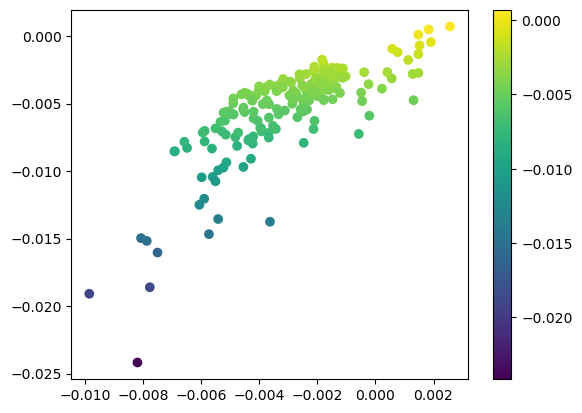

In [23]:
plt.scatter(a.SX,a.SY,c=a.SY)
plt.colorbar()

## Collocation points and auxiliary vectors

In [32]:
## Collocation points for PDF
# vamos a imponerla en toda la región 3D
min_X=final_data["X"].min()
max_X=final_data["X"].max()

min_Y=final_data["Y"].min()
max_Y=final_data["Y"].max()

min_Z=final_data["Z"].min()
max_Z=final_data["Z"].max()

Pos_min = torch.tensor([min_X, min_Y, min_Z])
Pos_max = torch.tensor([max_X, max_Y, max_Z])


num_coloc_points_x=60
num_coloc_points_y=60
num_coloc_points_z=60

X_coloc = np.random.uniform(min_X, max_X, (num_coloc_points_x, 1))
Y_coloc = np.random.uniform(min_Y, max_Y, (num_coloc_points_y, 1))
Z_coloc = np.random.uniform(min_Z, max_Z, (num_coloc_points_z, 1))
comb_array = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
train_coloc = torch.tensor(comb_array,requires_grad=True).to(device)                         # Convert to tensor the collocation points

train_coloc.shape

torch.Size([216000, 3])

In [33]:
# Collocation point for BC
# estos son los puntos donde obligaré a que haya una TENSION concreta, la cual viene determinada por las fuerzas nodales aplicadas

# se están aplicando fuerzas en algunos nodos con limitaciones, esto no debería influir, pues si el desplazamiento es nulo, tambien la tension.  
# aunque la tensión real que aparece ahi no es nula 
nodos_with_force_data=final_data.loc[final_data.apply(lambda x : (not np.isnan(x.Fuerza)) & (not np.isnan(x.SY)),axis=1),["X","Y","Z","SX","SY","SZ","SXY","SYZ","SXZ"]]
nodos_with_force_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ
Node,,,,,,,,,
6.0,27.108,57.070,47.311,-0.003914,-0.007067,-0.003272,-0.000960,0.002325,-0.000228
181.0,26.161,50.981,29.122,0.001909,-0.000448,0.001249,-0.001509,0.000435,-0.000824
182.0,26.443,50.288,27.876,0.001283,-0.002810,-0.000039,-0.002598,-0.000253,-0.001141
183.0,27.980,49.724,25.295,-0.000572,-0.007253,0.001545,-0.002296,0.002502,-0.001081
184.0,27.784,49.479,25.129,-0.003629,-0.013755,-0.001093,-0.004871,0.001492,-0.001278
...,...,...,...,...,...,...,...,...,...
1213.0,39.288,58.288,45.709,-0.002452,-0.003740,-0.000962,0.000103,-0.000078,-0.000213
1214.0,42.720,58.336,45.498,-0.002060,-0.003153,-0.000480,0.000054,0.000093,0.000120
1215.0,46.066,58.293,46.134,-0.002017,-0.003554,-0.000690,0.000037,-0.000205,0.000311


Estan poniendo como condición de contorno un stress. Es decir, que estamos dividiendo la fuerza aplicada por la superficie de aplicación para así tener una presión, que será el esfuerzo sobre cada nodo. Si por el contrario, aplicamos una fuerza sobre cada nodo de X newtons, lo que necesitamos en teoria es o la tension o la fuerza por volumen, tengo que aclararme con esto.   



In [34]:
# Por último. las condiciones de Dirichlet para la data  
# para los puntos totalmente quietos, los metemos todos, para los de una sola dirección, tambien metemos todos los de esa dirección
# y para el resto, metemos unos cuantos en temas de desplazamientos
# en lo que se limita solo una direcciones, podemos meter la limitación ahi de TODOS, pero del resto no 

data_BC_fix3=final_data.loc[final_data.apply(lambda x : len(x["Restricciones"])==3 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix1_Y=final_data.loc[final_data.apply(lambda x : len(x["Restricciones"])==1 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix3

,X,Y,Z,UX,UY,UZ
Node,,,,,,
58.0,19.605,32.193,40.349,0.0,0.0,0.0
173.0,19.692,50.419,40.542,0.0,0.0,0.0
174.0,20.263,50.465,39.107,0.0,0.0,0.0
175.0,21.075,50.964,38.226,0.0,0.0,0.0
176.0,21.767,51.016,36.943,0.0,0.0,0.0
...,...,...,...,...,...,...
3255.0,26.440,39.451,32.270,0.0,0.0,0.0
3263.0,53.808,44.100,29.981,0.0,0.0,0.0
3264.0,54.269,45.010,26.763,0.0,0.0,0.0


In [35]:
not_limited_nodes_data=final_data.loc[final_data.apply(lambda x : np.isnan(x["Restricciones"]) if not isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
not_limited_nodes_data

,X,Y,Z,UX,UY,UZ
Node,,,,,,
1.0,46.726,41.840,17.459,0.383590,-1.64530,-0.519970
2.0,31.149,44.342,17.410,-0.317510,-1.94210,-0.684740
4.0,63.720,39.982,42.026,0.212900,-0.21741,-0.096805
5.0,19.543,50.820,41.746,-0.142780,-0.44734,0.251500
6.0,27.108,57.070,47.311,-0.022577,-2.65550,0.638280
...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,0.227120,-0.64232,0.380410
4148.0,43.244,36.666,35.819,0.096754,-0.75938,0.206120
4149.0,46.140,37.853,37.430,0.156120,-0.75100,0.271850


In [36]:
notlimited_traindata=not_limited_nodes_data.sample(frac=0.8,axis=0)
notlimited_testdata=not_limited_nodes_data.loc[[i not in notlimited_traindata.index for i in not_limited_nodes_data.index]]
notlimited_traindata

,X,Y,Z,UX,UY,UZ
Node,,,,,,
3662.0,51.781,46.940,47.812,0.417610,-1.29660,0.74166
3600.0,38.153,29.926,29.579,-0.002165,-0.30399,0.10166
319.0,63.556,44.831,47.343,0.460370,-0.58731,0.08924
2790.0,24.325,33.040,49.124,-0.440970,-0.58196,0.31368
1046.0,37.612,57.346,41.868,0.061300,-3.28890,0.36934
...,...,...,...,...,...,...
3081.0,41.155,53.741,46.390,-0.003319,-2.47460,0.89224
1634.0,22.614,32.772,52.410,-0.526360,-0.74744,0.27298
4092.0,34.842,35.325,45.012,-0.125430,-0.66354,0.57158


In [33]:
#px.scatter_3d(not_limited_nodes_data,x="X",y="Y",z="Z",color="UX")


Los datos que usaremos para entrenar sera el 70% de los datos no limitados + los datos limitados en 1 y 3 direcciones.  
Y validaremos con los datos del 30% no limitados.  

In [37]:
train_data=pd.concat([notlimited_traindata,data_BC_fix3,data_BC_fix1_Y])
train_data=train_data.sample(frac=1)
train_data

,X,Y,Z,UX,UY,UZ
Node,,,,,,
4075.0,27.620,36.119,43.456,-0.278500,-0.54922,0.360810
2882.0,37.074,30.894,22.936,-0.092942,-0.75393,-0.138030
1600.0,43.753,36.872,59.758,0.219540,-0.92115,0.918520
1963.0,30.366,30.319,30.236,-0.146830,-0.26770,0.064421
23.0,27.451,25.543,50.376,-0.161000,0.00000,0.365060
...,...,...,...,...,...,...
2941.0,22.043,47.176,50.298,-0.527650,-1.15020,0.611150
1691.0,34.307,38.419,40.114,-0.116190,-0.91025,0.403220
507.0,41.689,32.072,18.670,0.103480,-1.22030,-0.232770


In [38]:
xyz_train=torch.tensor(train_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_train=torch.tensor(train_data[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

xyz_bc_train=torch.tensor(nodos_with_force_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
sigma_bc_train=torch.tensor(nodos_with_force_data[["SX","SY","SZ","SXY","SXZ","SYZ"]].to_numpy(),requires_grad=True).to(torch.float32).to(device)


In [39]:
xyz_test=torch.tensor(notlimited_testdata[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_test=torch.tensor(notlimited_testdata[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)


In [40]:
print(xyz_train.shape,uvw_train.shape,xyz_bc_train.shape,sigma_bc_train.shape,xyz_test.shape)

torch.Size([3452, 3]) torch.Size([3452, 3]) torch.Size([193, 3]) torch.Size([193, 6]) torch.Size([699, 3])


Resumen, tenemos por un lado la physic loss que serán en muchos puntos por todo el dominio.  
En los puntos de fuerzas aplicadas, tendremos las BC loss.  
En los puntos con restricciones tendremos todos los puntos disponibles, y si la restricciones e unidireccional, pues en esa dirección. Y sumada a esta, las loss de la data.  

## Deep NN class

In [41]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.layers=layers
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        # xn = normalize(x, Pos_min, Pos_max)         # Normalize the input

        # #convert to float
        # a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](x)
                        
            x = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](x)
        
        return a

## PINN class

In [45]:
class PINN:
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialize iterator'
        self.iter = 0
        
        # 'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        # self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        # 'Register parametes to be optimized'
        # self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        # 'Register our new parameter'
        # self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        
        # 'Parameters trials'
        # self.params_history = {"G": [] }

    def loss_data(self, x, u_real, save = False):
        #aqui están las restricciones de movimiento tanto de xyz como las de y solo
        #estamo suponiendo que eso es suficiente para que la red lo aprenda
        #le estamos metiendo todos los nodos que están quietos, y también le vamos a meter
        #todos los que solo se pueden desplazar en dos direcciones, 

        #esta pendiente, en estos con una restriccion en una sola dirección, calcular la loss
        #SOLO en esa direccion 

        
        u_nn = self.dnn(x)
     
        loss_d = self.loss_function(u_nn, u_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):
                       
        # clone the input data and add AD
       
        pos = pos_f.clone().to(torch.float32)
        ##pos.requires_grad = True

        # predict u
        U = self.dnn(pos)

        #primeras derivadas 

        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # u_x = dU[:,0].reshape(-1,1)
        # v_y = dU[:,1].reshape(-1,1)
        # w_z = dU[:,2].reshape(-1,1)

        U_shifted1 = torch.roll(U, 1, 1)
        dU_1 = autograd.grad(U_shifted1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # w_x = dU_1[:,0].reshape(-1,1)
        # u_y = dU_1[:,1].reshape(-1,1)
        # v_z = dU_1[:,2].reshape(-1,1)

        U_shifted2 = torch.roll(U, 1, 1)
        dU_2 = autograd.grad(U_shifted2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # v_x = dU_2[:,0].reshape(-1,1)
        # w_y = dU_2[:,1].reshape(-1,1)
        # u_z = dU_2[:,2].reshape(-1,1)
        
        # second derivatives

        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)
        w_zz = ddU[:,2].reshape(-1,1)

        ddU_1 = autograd.grad(dU_1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xx = ddU_1[:,0].reshape(-1,1)
        u_yy = ddU_1[:,1].reshape(-1,1)
        v_zz = ddU_1[:,2].reshape(-1,1)

        ddU_2 = autograd.grad(dU_2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xx = ddU_2[:,0].reshape(-1,1)
        w_yy = ddU_2[:,1].reshape(-1,1)
        u_zz = ddU_2[:,2].reshape(-1,1)


        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        cross_ddU_1 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xz = cross_ddU_1[:,0].reshape(-1,1)
        u_yx = cross_ddU_1[:,1].reshape(-1,1)
        v_zy = cross_ddU_1[:,2].reshape(-1,1)

        cross_ddU_2 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xy = cross_ddU_2[:,0].reshape(-1,1)
        w_yz = cross_ddU_2[:,1].reshape(-1,1)
        u_zx = cross_ddU_2[:,2].reshape(-1,1)


        # PDE f = 0
        # f = [ (2*G)/(1-nu) * (u_xx + nu*v_yx) + G*(u_xy+ v_yy) ,  
        #       G*(u_xx + v_yx) + (2*G)/(1-nu)*(v_yy + nu*u_xy) ]
        # f_tensor= torch.cat((f[0] , f[1]), dim=1).to(torch.float32)

        f = [(u_xx+u_yy+u_zz) + (1)/(1-2*nu)*(u_xx + v_xy + w_xz),
             (v_xx+v_yy+v_zz) + (1)/(1-2*nu)*(u_yx + v_yy + w_yz),
             (w_xx+w_yy+w_zz) + (1)/(1-2*nu)*(u_zx + v_zy + w_zz) ]

        f_tensor= torch.cat((f[0], f[1], f[2]), dim=1).to(torch.float32).to(device)
        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor).to(torch.float32).to(device) ) 

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc,sigma_bc, save = False):
        #nuestras condiciones serán hacer que en los nodos donde se aplica la fuerza, las tensiones 
        #sean las registradas para la dirección en la que se aplican, -Y
        
        # clone the input data and add AD
        pos = pos_bc.clone().to(torch.float32)
        
        # predict U
        X,Y,Z=self.compute_XYZ(pos_bc)
        U,V,W=self.compute_displacements(X,Y,Z)
        
        #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
        nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


        #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
        sigma=self.compute_stress(strain)

        loss_bc = self.loss_function(sigma.to(torch.float32), sigma_bc.to(torch.float32)) 
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc


    def loss(self, pos_real, despl_real, pos_f, pos_bc,sigma_bc, save = False):

        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE( pos_f, save) 
        loss_bc = self.loss_BC(pos_bc,sigma_bc, save)
        
        # weights should sum 1
        #valores_aux=np.array([loss_f.to('cpu').detach().numpy().item(),loss_d.to('cpu').detach().numpy().item(),loss_bc.to('cpu').detach().numpy().item()])
        loss_val =loss_d  + loss_f + loss_bc

        save and self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
        return loss_val

    def compute_gradU( self, u, v, w, X, Y, Z, eye=torch.eye(3)):
        # Compute the gradient of U
        Ux = autograd.grad(u, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uy = autograd.grad(u, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uz = autograd.grad(u, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx = autograd.grad(v, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vy = autograd.grad(v, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vz = autograd.grad(v, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of W
        Wx = autograd.grad(w, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wy = autograd.grad(w, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wz = autograd.grad(w, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,0,0,1),(0,1,2,1,2,2)]
        return torch.matmul(C,strain_flat.T.float()).T.squeeze()
    
    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone()
        X = pos[:,0].reshape(-1,1)
        #X.requires_grad = True
        Y = pos[:,1].reshape(-1,1)
        #Y.requires_grad = True
        Z = pos[:,2].reshape(-1,1)
        #Z.requires_grad = True
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1)

        # Compute the output of the DNN
        U = self.dnn(XYZ)               

        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)

        return u, v, w


In [46]:
'Neural Network Summary'
layers=[3,20,20,20,20,20,20,3]
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

optimizer = torch.optim.Adam(pinn_LBFGS.dnn.parameters(), lr=1e-3)
epochs=2000

'Time'
start_time = time.time()

for i,epoch in enumerate(range(epochs)):
    print(epoch)
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs_xyz = pinn_LBFGS.dnn(xyz_train)

    # Compute the loss and its gradients
    loss = pinn_LBFGS.loss(xyz_train, uvw_train, train_coloc, xyz_bc_train,sigma_bc_train, save = True)
    loss.backward()
    print(
            'Adam iter: %d, Loss error(Train): %.10f ' %
            (   
                i,
                loss.cpu().detach().numpy(),
            )
        )

    # Adjust learning weights
    optimizer.step()

    


elapsed_time_LBFGS = time.time() - start_time
print('Elapsed time: %.10f seconds.' % elapsed_time_LBFGS)

0
Adam iter: 0, Loss error(Train): 0.6899996400 
1
Adam iter: 1, Loss error(Train): 0.6070142984 
2
Adam iter: 2, Loss error(Train): 0.5336390138 
3
Adam iter: 3, Loss error(Train): 0.4701671898 
4
Adam iter: 4, Loss error(Train): 0.4166745543 
5
Adam iter: 5, Loss error(Train): 0.3727683723 
6
Adam iter: 6, Loss error(Train): 0.3376443088 
7
Adam iter: 7, Loss error(Train): 0.3102509677 
8
Adam iter: 8, Loss error(Train): 0.2894285321 
9
Adam iter: 9, Loss error(Train): 0.2740614712 
10
Adam iter: 10, Loss error(Train): 0.2631896138 
11
Adam iter: 11, Loss error(Train): 0.2560043037 
12
Adam iter: 12, Loss error(Train): 0.2517427802 
13
Adam iter: 13, Loss error(Train): 0.2495734692 
14
Adam iter: 14, Loss error(Train): 0.2485751063 
15
Adam iter: 15, Loss error(Train): 0.2478561252 
16
Adam iter: 16, Loss error(Train): 0.2467329800 
17
Adam iter: 17, Loss error(Train): 0.2448402196 
18
Adam iter: 18, Loss error(Train): 0.2421333790 
19
Adam iter: 19, Loss error(Train): 0.2388073057 


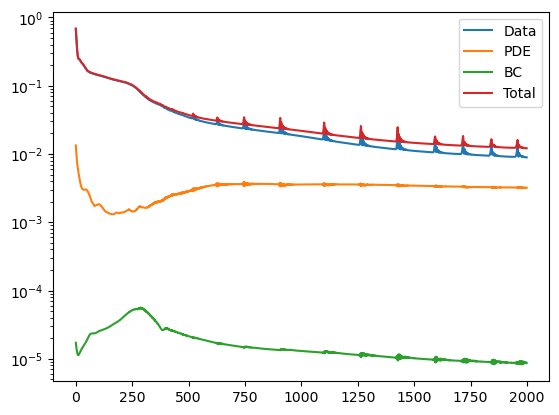

In [47]:
plt.plot(pinn_LBFGS.loss_history["Data"], label='Data')
plt.plot(pinn_LBFGS.loss_history["PDE"], label='PDE')
plt.plot(pinn_LBFGS.loss_history["BC"], label='BC')
plt.plot(pinn_LBFGS.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig('PINN_LEP_Losses.png')

In [103]:

U = pinn_LBFGS.dnn(xyz_train)



In [112]:
pred_u_df=pd.DataFrame(U.cpu().detach().numpy(),columns=["U_pred","V_pred","W_pred"],index=train_data.index)

In [ ]:
notlimited_traindata

In [115]:
pred_final=pd.concat([notlimited_traindata,pred_u_df],axis=1)
pred_final

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred
Node,,,,,,,,,
3662.0,51.781,46.940,47.812,0.083522,-0.259310,0.148330,0.030641,-0.150597,0.091434
3600.0,38.153,29.926,29.579,-0.000433,-0.060799,0.020331,0.037557,-0.111747,0.062338
319.0,63.556,44.831,47.343,0.092075,-0.117460,0.017848,0.044082,-0.080236,0.056847
2790.0,24.325,33.040,49.124,-0.088194,-0.116390,0.062737,-0.087704,-0.097599,0.085362
1046.0,37.612,57.346,41.868,0.012260,-0.657790,0.073868,-0.007179,-0.295652,0.018880
...,...,...,...,...,...,...,...,...,...
795.0,NaN,NaN,NaN,NaN,NaN,NaN,0.001206,-0.369521,-0.017357
1801.0,NaN,NaN,NaN,NaN,NaN,NaN,0.062898,-0.042122,0.010139
403.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.016556,-0.034523,0.085847


In [116]:
rel_error_U=((U-uvw_train)/uvw_train).cpu().detach().numpy()
ee_rel_error=rel_error_U[:,0]**2+rel_error_U[:,1]**2+rel_error_U[:,2]**2

In [117]:
pred_final["rel_error"]=ee_rel_error
pred_final

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,
3662.0,51.781,46.940,47.812,0.083522,-0.259310,0.148330,0.030641,-0.150597,0.091434,1.981051
3600.0,38.153,29.926,29.579,-0.000433,-0.060799,0.020331,0.037557,-0.111747,0.062338,10.687613
319.0,63.556,44.831,47.343,0.092075,-0.117460,0.017848,0.044082,-0.080236,0.056847,1.734374
2790.0,24.325,33.040,49.124,-0.088194,-0.116390,0.062737,-0.087704,-0.097599,0.085362,26.863348
1046.0,37.612,57.346,41.868,0.012260,-0.657790,0.073868,-0.007179,-0.295652,0.018880,inf
...,...,...,...,...,...,...,...,...,...,...
795.0,NaN,NaN,NaN,NaN,NaN,NaN,0.001206,-0.369521,-0.017357,0.317823
1801.0,NaN,NaN,NaN,NaN,NaN,NaN,0.062898,-0.042122,0.010139,0.043969
403.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.016556,-0.034523,0.085847,1.346806


/home/arturosf/anaconda3/envs/main_torch/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning:

invalid value encountered in reduce



(-5.0, 5.0)

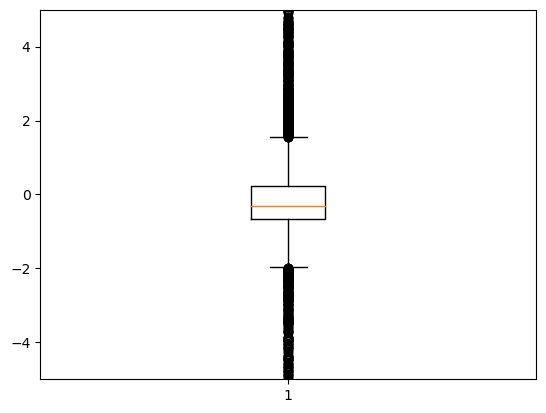

In [118]:
plt.boxplot(rel_error_U.flatten())
plt.ylim(-5,5)

In [119]:
pred_final.loc[pred_final["rel_error"]<0.01]

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,
1643.0,30.428,32.179,57.095,-0.069748,-0.134900,0.138730,-0.038981,-0.046020,0.080063,0.007415
3311.0,61.043,46.818,46.694,0.084110,-0.131100,0.050756,0.041693,-0.084043,0.054729,0.005628
773.0,19.299,50.182,41.159,-0.010712,-0.033421,0.011261,0.005668,-0.271548,0.083769,0.007489


In [120]:
pred_final.loc[pred_final["rel_error"]>1]

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,
3662.0,51.781,46.940,47.812,0.083522,-0.259310,0.148330,0.030641,-0.150597,0.091434,1.981051
3600.0,38.153,29.926,29.579,-0.000433,-0.060799,0.020331,0.037557,-0.111747,0.062338,10.687613
319.0,63.556,44.831,47.343,0.092075,-0.117460,0.017848,0.044082,-0.080236,0.056847,1.734374
2790.0,24.325,33.040,49.124,-0.088194,-0.116390,0.062737,-0.087704,-0.097599,0.085362,26.863348
1046.0,37.612,57.346,41.868,0.012260,-0.657790,0.073868,-0.007179,-0.295652,0.018880,inf
...,...,...,...,...,...,...,...,...,...,...
702.0,NaN,NaN,NaN,NaN,NaN,NaN,0.050983,-0.107428,0.102988,1.046808
736.0,NaN,NaN,NaN,NaN,NaN,NaN,0.016312,-0.340659,0.050166,5.727315
559.0,NaN,NaN,NaN,NaN,NaN,NaN,0.061081,-0.014987,-0.021389,2.328005


In [121]:
import plotly.graph_objects as go

fig = go.Figure()

# Agregar los puntos con rel_error < 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] < 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] < 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] < 1]["Z"],
    mode='markers',
    marker=dict(
        color=pred_final.loc[pred_final["rel_error"] < 1]["rel_error"],
        colorscale='Viridis',
        size=5,
        colorbar=dict(
            title='Rel_error',
            titleside='right',
            tickmode='auto',
            ticks='outside',
            tickcolor='white',
            ticklen=5,
            showticksuffix='last',
            thickness=20
        )
    ),
    name='Rel_error < 1'
))

# Agregar los puntos con rel_error > 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] > 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] > 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] > 1]["Z"],
    mode='markers',
    marker=dict(
        color='grey',
        opacity=0.5,
        size=5
    ),
    name='Rel_error > 1'
))

# Actualizar el diseño del gráfico
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Mostrar el gráfico
fig.show()
